<a href="https://colab.research.google.com/github/maazbinadnan/Neural-Networks/blob/main/ImageProcessingProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import os
import numpy as np
import torch.nn as nn
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
import torch.optim as optim


In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
import zipfile

# Specify the path to the ZIP file
zip_path = '/content/drive/MyDrive/dataset/artists.zip'  # Replace with the actual path to your ZIP file

# Extract the contents of the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/sample_data/imagedata')

Loading Data and Preprocessing the image

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Set the path to your image directory
data_dir = '/content/sample_data/imagedata'


# Define the transformation to apply to the images
transform_train = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(size=224),
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.ToTensor(),  # Convert images to tensors  # take random crop of 224 by 224
    # Normalize pixel values using ImageNet dataset values
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),

])
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(size=224),  # Resize images to a consistent size
    transforms.ToTensor(),  # Convert images to tensors
    # Normalize pixel values using ImageNet dataset values
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create an instance of the ImageFolder dataset
dataset = ImageFolder(data_dir, transform=transform_train)

# Split the dataset into train and test sets
train_ratio = 0.8  # Ratio of training data (80%)
dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
test_size = dataset_size - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

# Create data loaders for train and test sets
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Print the number of samples in train and test sets
print("Train set size:", len(train_set))
print("Test set size:", len(test_set))

cuda
Train set size: 4547
Test set size: 1137


39
torch.Size([3, 224, 224])


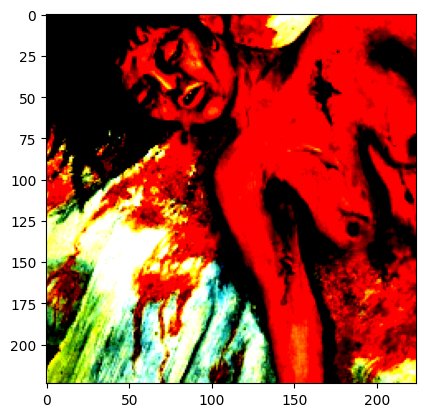

In [47]:
import matplotlib.pyplot as plt

img,label = train_set[0]
img2 = test_set[0]
print(len(train_set.dataset.classes))
print(img.shape)
#draw the image
plt.imshow(img.permute(1,2,0))



Building a RESNET with no weights


In [49]:
resnet = models.resnet18()
num_classes = 10
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
resnet.to(device)
criterion = nn.CrossEntropyLoss()
lr = 0.001
optimizer=optim.Adam(resnet.parameters(),lr=lr)
print(resnet)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Training Loop

In [51]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

num_epochs =25
for epoch in range(num_epochs):
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}")

RuntimeError: ignored

In [11]:
correct = 0
total = 0

# Put the model in evaluation mode
resnet.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = resnet(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 53.18%


In [ ]:
correct_top3 = 0
total = 0

# Put the model in evaluation mode
resnet.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = resnet(inputs)
        _, predicted_top3 = outputs.topk(3, 1)  # Get top-3 predicted labels
        
        total += labels.size(0)
        for i in range(labels.size(0)):
            if labels[i] in predicted_top3[i]:
                correct_top3 += 1

test_top3_accuracy = 100 * correct_top3 / total
print(f"Top-3 Test Accuracy: {test_top3_accuracy:.2f}%")


Building a resnet with pre-trained weights


In [23]:
resnet2 = models.resnet18()
num_classes = 10
resnet2.fc = nn.Linear(resnet.fc.in_features, num_classes)
resnet2.to(device)
criterion = nn.CrossEntropyLoss()
lr = 0.001
optimizer=optim.Adam(resnet.parameters(),lr=lr)
print(resnet2)


FileNotFoundError: ignored

In [20]:
num_epochs =25
for epoch in range(num_epochs):
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = resnet2(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}")

Epoch 1/25 - Loss: 2.3458
Epoch 2/25 - Loss: 2.3392
Epoch 3/25 - Loss: 2.3402
Epoch 4/25 - Loss: 2.3377
Epoch 5/25 - Loss: 2.3493
Epoch 6/25 - Loss: 2.3429
Epoch 7/25 - Loss: 2.3433
Epoch 8/25 - Loss: 2.3437
Epoch 9/25 - Loss: 2.3413
Epoch 10/25 - Loss: 2.3487
Epoch 11/25 - Loss: 2.3466
Epoch 12/25 - Loss: 2.3277
Epoch 13/25 - Loss: 2.3472
Epoch 14/25 - Loss: 2.3352
Epoch 15/25 - Loss: 2.3403
Epoch 16/25 - Loss: 2.3376
Epoch 17/25 - Loss: 2.3375
Epoch 18/25 - Loss: 2.3387
Epoch 19/25 - Loss: 2.3403
Epoch 20/25 - Loss: 2.3366
Epoch 21/25 - Loss: 2.3373
Epoch 22/25 - Loss: 2.3331
Epoch 23/25 - Loss: 2.3428
Epoch 24/25 - Loss: 2.3337
Epoch 25/25 - Loss: 2.3365


In [21]:
correct = 0
total = 0

# Put the model in evaluation mode
resnet.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = resnet2(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 10.27%


In [22]:
correct_top3 = 0
total = 0

# Put the model in evaluation mode
resnet2.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = resnet2(inputs)
        _, predicted_top3 = outputs.topk(3, 1)  # Get top-3 predicted labels
        
        total += labels.size(0)
        for i in range(labels.size(0)):
            if labels[i] in predicted_top3[i]:
                correct_top3 += 1

test_top3_accuracy = 100 * correct_top3 / total
print(f"Top-3 Test Accuracy: {test_top3_accuracy:.2f}%")


Top-3 Test Accuracy: 36.55%
